In [15]:
#Import relevant libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Import PCA module from SKLearn
from sklearn.decomposition import PCA, FactorAnalysis
#Import factor analysis libraries for running Factor Analaysis
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity as cbs
from factor_analyzer.factor_analyzer import calculate_kmo as c_kmo
from factor_analyzer import FactorAnalyzer

In [16]:
#Imports dataset from c
sd = pd.read_csv('./datasets/IPIP_dataset.csv')

In [17]:
#Drops all columns containing null values over 200
sd = sd.loc[:, (sd.isnull().sum(axis=0) <= 200)]
#Drops all rows with null values
sd.dropna(inplace=True)

In [18]:
#List comprehension identifying all columns starting with word 'subjective'
# cols_to_include = sd.drop(['subject_id', 'wave'], axis=1)
cols_to_include = sd.copy()
#Calculates the standardised (z-score) for each point and updates these to the dataframe
cols_to_include_org = cols_to_include.copy()
cols_to_include = (cols_to_include - cols_to_include.mean())/cols_to_include.std()

In [19]:
# A:
#Specify the number of components to extract. In this case is using mle rather than a pre-specified value
n_components_output = 'mle'
#Initalises an empty PCA classifier
pca = PCA(n_components=n_components_output)
#Fit the PCA on the target data frame values 
pca.fit(cols_to_include.values)

#This identifies the number of components extracted if n_component_output is not specified as an integer
n_components_found = len(pca.components_)

#Get the column names for use in labelling the index and help identify which features loading on each component
index_list = cols_to_include.columns
#Set the eigenvectors to highlight in the final output. This is for visual aid in identifying more important weightings
flag_value = 0.1
#set the precision (decimal places) for output
precision_level = 3

#Create an empty pricpals components list to append the names of each Principle component
principals_list = []

#create names for each principal component
for pc in range(1,n_components_found+1):
    principals_list.append(str("Principal Component " + str(pc)))

#Create a Dataframe with eigenvectors for each component and append the names to the index
Factor_loadings = pd.DataFrame(data=pca.components_.T,columns=principals_list, index=index_list)

#This obtains the eigenvectors and appends these to the bottom of the factor_loadings table
eig_columns = ['Eigenvalue']
exp_var_eigenvals = pd.DataFrame(pca.explained_variance_, columns=eig_columns,index=principals_list).T
Factor_loadings = Factor_loadings.append(exp_var_eigenvals)

#This obtains the variance explained % for each component and appends this to the bottom of the factor_loadings table
variance_explained_label = ['Variance Explained %']
exp_var_pct = pd.DataFrame(pca.explained_variance_ratio_, columns=variance_explained_label,index=principals_list).T
Factor_loadings = Factor_loadings.append(exp_var_pct)


#Applying style sheet to the pandas sheet based on the flag value. 
Factor_loadings.style.apply(lambda x: ["background: lightgreen" if v > flag_value 
                                       else "background: lightyellow" if v < (0-flag_value)
                                       else "" for v in x], axis=1,subset=pd.IndexSlice[index_list,principals_list]).set_precision(precision_level)

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,Principal Component 10,Principal Component 11,Principal Component 12,Principal Component 13,Principal Component 14,Principal Component 15,Principal Component 16,Principal Component 17,Principal Component 18,Principal Component 19,Principal Component 20,Principal Component 21,Principal Component 22,Principal Component 23,Principal Component 24,Principal Component 25,Principal Component 26,Principal Component 27
Am the life of the party,0.23,0.0651,-0.0189,-0.281,-0.082,-0.0623,0.179,0.155,-0.2,-0.0842,-0.0345,-0.032,0.0333,-0.000451,0.0838,0.257,-0.00712,-0.0832,-0.0138,-0.0732,-0.00991,-0.11,-0.0877,-0.0747,0.00791,0.219,-0.16
Feel little concern for others,-0.0176,0.0394,-0.293,-0.128,-0.0595,-0.0634,0.354,-0.0459,-0.158,-0.0404,0.0378,0.0448,-0.132,-0.217,0.0178,-0.279,-0.0968,-0.0553,-0.0325,-0.126,0.093,0.164,0.0732,-0.04,-0.134,0.0288,0.338
Am always prepared,0.15,0.192,-0.151,0.083,-0.0724,-0.0192,-0.24,-0.104,-0.151,-0.0573,0.0161,-0.0514,-0.057,-0.139,0.0987,0.241,-0.141,-0.0751,0.193,-0.0638,0.0294,-0.0357,0.181,0.109,0.246,-0.109,-0.0315
Get stressed out easily,-0.206,0.216,-0.0287,-0.0527,0.0507,-0.156,0.102,0.0592,0.0898,0.0335,0.00599,0.221,-0.0341,0.0653,0.176,-0.121,-0.0108,0.0413,-0.0175,0.0195,0.27,-0.115,-0.11,0.247,0.294,-0.0974,-0.114
Have a rich vocabulary,0.0707,-0.0765,0.151,0.218,0.0201,0.0279,0.011,-0.386,-0.226,0.0563,-0.104,0.0283,-0.0208,0.157,0.0285,-0.176,-0.0825,0.0574,0.073,-0.0106,-0.143,-0.152,0.386,0.117,0.0853,0.132,0.00462
Don't talk a lot,-0.215,-0.0737,-0.238,0.125,0.0481,-0.252,-0.0278,-0.0239,0.00669,-0.073,-0.087,-0.00191,0.126,-0.133,-0.0205,-0.0516,0.0436,0.0106,0.0271,0.0637,-0.0357,-0.403,-0.134,-0.136,-0.0817,0.0733,-0.0433
Am interested in people,0.0892,0.189,0.118,-0.0365,0.156,-0.14,-0.0852,0.0403,-0.00257,-0.08,-0.0311,0.162,0.289,-0.134,0.19,-0.0127,0.211,-0.198,0.105,0.27,0.0305,-0.00421,0.227,-0.111,-0.0981,-0.0104,0.327
Leave my belongings around,0.0397,-0.176,0.21,-0.0365,-0.167,0.315,-0.0362,-0.107,-0.135,0.117,0.0487,0.025,-0.146,-0.0597,0.066,-0.0677,0.126,-0.159,0.0336,0.101,0.216,0.149,0.0939,-0.101,0.111,-0.119,-0.183
Am relaxed most of the time,0.115,-0.149,0.0123,-0.0588,0.112,0.00199,-0.321,0.198,-0.131,-0.0206,-0.0366,0.324,0.0614,-0.205,0.068,-0.0336,0.111,-0.0855,0.157,-0.166,-0.299,-0.003,-0.0679,-0.037,0.136,-0.00886,0.0921
Have difficulty understanding abstract ideas,-0.175,0.0424,-0.0931,-0.074,0.0374,0.145,-0.0922,0.0713,-0.146,-0.205,0.269,0.284,0.166,0.0773,0.218,-0.223,0.0371,0.0964,-0.0359,-0.1,-0.000833,0.0432,0.161,-0.111,0.00373,0.122,-0.34


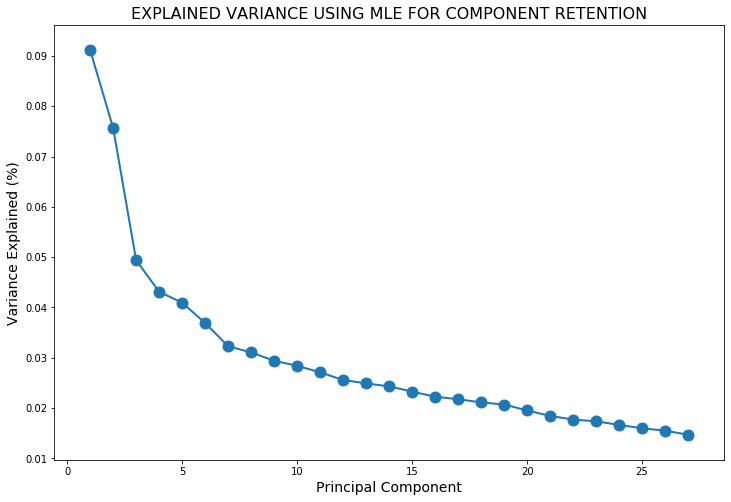

In [20]:
if isinstance(n_components_output, str):
    title_fig = str('Explained Variance Using ' + n_components_output + ' for component retention').upper()
elif isinstance(n_components_output, int):
    title_fig = str('Explained Variance using ' + n_components_output + ' components').upper()
else:
    title_fig = str('Explained Variance %').upper()
    
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(list(range(1, len(pca.explained_variance_ratio_)+1)), exp_var_pct.T, lw=2)
ax.scatter(list(range(1, len(pca.explained_variance_ratio_)+1)), exp_var_pct.T, s=120)
ax.set_title(title_fig, fontsize=16)
ax.set_xlabel('Principal Component', fontsize=14)
ax.set_ylabel('Variance Explained (%)', fontsize=14)
plt.show()

### Factor Analysis

In [21]:
#This uses calculates Bartlett Test of Sphericity
chi_square_value = cbs(cols_to_include_org)
print("Bartlett Sphericity")
print("----------------------")
print("Test Value =", chi_square_value[0])
print("Test p value =", chi_square_value[1])

Bartlett Sphericity
----------------------
Test Value = 4602.619161824707
Test p value = 0.0


In [22]:
#Select cut-off for KMO highlight level (values less than this will be highlighted)
highlight_level = 0.6
#Create KMO Table
KMO = pd.Series(c_kmo(cols_to_include_org)[1],index=['KMO Value'])
kmo_values = pd.DataFrame(c_kmo(cols_to_include_org)[0],columns=['KMO Value'])
kmo_values = kmo_values.append(KMO, ignore_index=True)

index_KMO = list(cols_to_include_org.columns)
index_KMO.append("KMO")

kmo_dict = {}
for i, x in enumerate(index_KMO):
    kmo_dict.update({i:x})

kmo_values = kmo_values.rename(index=kmo_dict)

#Applying style sheet to the pandas sheet based on the flag value. 
kmo_values.style.apply(lambda x: ["background: lightyellow" if v < highlight_level
                                       else "" for v in x], 
                                       axis=1)

,KMO Value
Am the life of the party,0.634005
Feel little concern for others,0.49435
Am always prepared,0.691614
Get stressed out easily,0.651461
Have a rich vocabulary,0.497707
Don't talk a lot,0.607825
Am interested in people,0.591558
Leave my belongings around,0.611305
Am relaxed most of the time,0.547497
Have difficulty understanding abstract ideas,0.494927


In [23]:
#Specify the number of components to extract.
FA_n_factors = 5
#Specify rotation methods
FA_rotation = 'oblimin' 

#Initalises an empty FactorAnalyzer classifier
FA = FactorAnalyzer(n_factors=FA_n_factors, rotation=FA_rotation)
#Fit the factor analysis on the target data frame values 
FA.fit(cols_to_include_org.values)

# #Get the column names for use in labelling the index and help identify which features loading on each component
index_list = cols_to_include_org.columns
# #Set the eigenvectors to highlight in the final output. This is for visual aid in identifying more important weightings
flag_value = 0.3
# #set the precision (decimal places) for output
precision_level = 3

# #Create an empty pricpals components list to append the names of each Principle component
factors_list = []

# #create names for each principal component
for pc in range(1,FA_n_factors+1):
    factors_list.append(str("Factor " + str(pc)))

# #Create a Dataframe with eigenvectors for each component and append the names to the index
FA_loadings = pd.DataFrame(data=FA.loadings_,columns=factors_list, index=index_list)

#Creates a list of associated eigenvalues to append to bottom of FA_loadings table
FA_eigenvalues = []
for i in range(0,FA_n_factors):
    FA_eigenvalues.append(FA.get_eigenvalues()[0][i])

# # #This obtains the eigenvectors and appends these to the bottom of the factor_loadings table
eig_columns = ['Eigenvalue']   
fact_exp_var_eigenvals = pd.DataFrame(FA_eigenvalues, columns=eig_columns,index=factors_list).T
FA_loadings = FA_loadings.append(fact_exp_var_eigenvals)

#Calculate total Eigenvalues and then iterates through eigenvalues from FA and divides by sum to
#represent total variance explained
FA_eigenvalue_sum = sum(FA.get_eigenvalues()[0])
FA_eigenvalue_variance_list = []
for i in FA.get_eigenvalues()[0]:
    FA_eigenvalue_variance_list.append(i/FA_eigenvalue_sum)

# # #This obtains the variance explained % for each component and appends this to the bottom of the factor_loadings table
factor_variance_explained_label = ['Variance Explained %']
FA_eigenvalue_variance_append = pd.DataFrame(FA_eigenvalue_variance_list[:FA_n_factors],columns=factor_variance_explained_label,index=factors_list).T
FA_loadings = FA_loadings.append(FA_eigenvalue_variance_append)

#Applying style sheet to the pandas sheet based on the flag value. 
#Applying style sheet to the pandas sheet based on the flag value. 
FA_loadings.style.apply(lambda x: ["background: lightgreen" if v > flag_value 
                                       else "background: lightyellow" if v < (0-flag_value)
                                       else "" for v in x], 
                                       axis=1,
                                       subset=pd.IndexSlice[index_list,factors_list]).set_precision(precision_level)


,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
Am the life of the party,0.615,-0.0365,-0.0491,0.063,-0.128
Feel little concern for others,0.162,0.0527,0.183,-0.221,-0.283
Am always prepared,0.247,0.0111,0.401,0.00885,0.0749
Get stressed out easily,-0.159,0.293,0.183,0.205,-0.254
Have a rich vocabulary,-0.133,-0.138,-0.0515,0.0389,0.313
Don't talk a lot,-0.388,0.0201,0.148,-0.293,-0.195
Am interested in people,0.098,-0.0715,0.115,0.382,-0.0121
Leave my belongings around,0.0797,0.0631,-0.375,-0.0819,0.238
Am relaxed most of the time,0.0793,-0.273,-0.17,-0.0435,-0.0105
Have difficulty understanding abstract ideas,-0.142,0.156,0.0357,-0.0318,-0.231


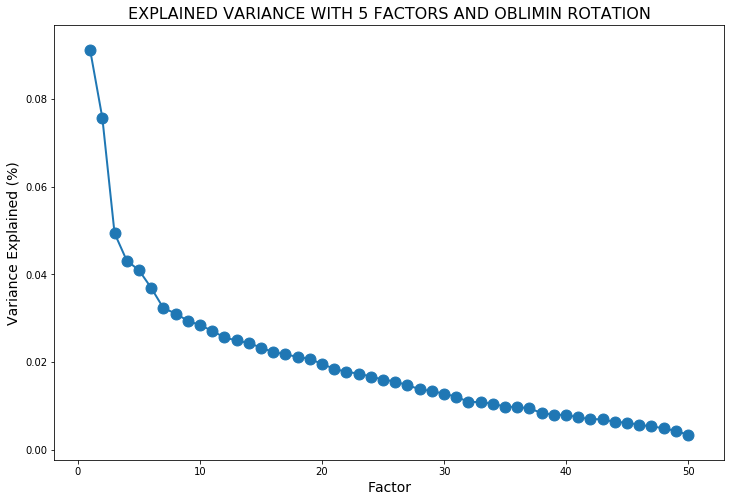

In [24]:
if isinstance(n_components_output, str):
    title_fig = str('Explained Variance with ' + str(FA_n_factors) + ' Factors and ' + FA_rotation + ' rotation').upper()
elif isinstance(n_components_output, int):
    title_fig = str('Explained Variance with ' + str(FA_n_factors) + ' Factors and ' + FA_rotation + ' rotation').upper()
else:
    title_fig = str('Explained Variance %').upper()
    
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(list(range(1, len(FA_eigenvalue_variance_list)+1)), FA_eigenvalue_variance_list, lw=2)
ax.scatter(list(range(1, len(FA_eigenvalue_variance_list)+1)), FA_eigenvalue_variance_list, s=120)
ax.set_title(title_fig, fontsize=16)
ax.set_xlabel('Factor', fontsize=14)
ax.set_ylabel('Variance Explained (%)', fontsize=14)
plt.show()